# Importing necessary libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
from xgboost import XGBClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split

# Importing the data to be used

In [2]:
generated_data_path = os.getcwd() + '/generated_data/'

all_dataframes = os.listdir(generated_data_path)
all_dataframes = natsorted(all_dataframes)

ecg_extracted_dataframe = pd.DataFrame()

# Extracted parameters from samples signals
for dataframe in all_dataframes:
    file_path = generated_data_path + dataframe
    current_dataframe = pd.read_csv(file_path, index_col = 'Unnamed: 0')
    current_pacient_rhythm = current_dataframe['rhythm'][0]
    current_dataframe = current_dataframe.mean()
    current_dataframe['rhythm'] = current_pacient_rhythm

    ecg_extracted_dataframe = pd.concat([ecg_extracted_dataframe, current_dataframe], axis=1)
ecg_extracted_dataframe = ecg_extracted_dataframe.T.reset_index()

ecg_extracted_dataframe.drop(
    ['index', 'qrs_start',  'qrs_end', 'qrs_peaks_channel_0',  'qrs_peaks_channel_1',  'qrs_peaks_channel_2',
    'qrs_peaks_channel_3',  'qrs_peaks_channel_4',  'qrs_peaks_channel_5',  'qrs_peaks_channel_6',
    'qrs_peaks_channel_7',  'qrs_peaks_channel_8',  'qrs_peaks_channel_9',  'qrs_peaks_channel_10',
    'qrs_peaks_channel_11',  't_start',  't_end',  't_peaks_channel_0',  't_peaks_channel_1',
    't_peaks_channel_2',  't_peaks_channel_3',  't_peaks_channel_4', 't_peaks_channel_5',
    't_peaks_channel_6',  't_peaks_channel_7',  't_peaks_channel_8',  't_peaks_channel_9',
    't_peaks_channel_10',  't_peaks_channel_11',  'p_start',  'p_end',  'p_peaks_channel_0',
    'p_peaks_channel_1',  'p_peaks_channel_2',  'p_peaks_channel_3',  'p_peaks_channel_4',
    'p_peaks_channel_5',  'p_peaks_channel_6',  'p_peaks_channel_7',  'p_peaks_channel_8',
    'p_peaks_channel_9',  'p_peaks_channel_10', 'p_peaks_channel_11'], axis=1, inplace=True)

ecg_extracted_dataframe.head()

,qrs_interval,qrs_amplitude_channel_0,qrs_amplitude_channel_1,qrs_amplitude_channel_2,qrs_amplitude_channel_3,qrs_amplitude_channel_4,qrs_amplitude_channel_5,qrs_amplitude_channel_6,qrs_amplitude_channel_7,qrs_amplitude_channel_8,...,st_deviation_channel_3,st_deviation_channel_4,st_deviation_channel_5,st_deviation_channel_6,st_deviation_channel_7,st_deviation_channel_8,st_deviation_channel_9,st_deviation_channel_10,st_deviation_channel_11,rhythm
0,0.12,0.90,0.85,-0.77,-0.89,0.89,0.54,-0.75,0.59,0.73,...,0.04,-0.02,-0.04,0.02,0.00,-0.02,-0.02,-0.03,-0.02,Sinusbradycardia
1,0.12,0.57,0.70,0.42,-0.71,0.26,0.64,-0.64,-0.58,-0.61,...,-0.03,-0.04,0.05,0.03,0.06,0.05,0.03,0.02,0.02,Sinusrhythm
2,0.13,0.66,0.88,0.86,-0.88,-0.74,0.88,-0.76,-0.69,-0.61,...,0.04,-0.01,-0.01,0.05,0.05,0.04,0.00,-0.02,-0.03,Sinusrhythm
3,0.12,0.74,0.33,-0.52,-0.61,0.64,-0.27,-0.64,-0.38,-0.38,...,-0.02,0.00,0.02,0.06,0.05,0.05,0.03,0.02,0.01,Sinusrhythm
4,0.12,0.81,0.67,-0.44,-0.76,0.72,0.29,-0.66,-0.53,-0.55,...,-0.01,-0.03,0.06,0.02,0.03,0.03,0.01,0.00,0.02,Sinusrhythm


# Preparing the data

In [3]:
# Using LazyClassifier to choose the best models
data = ecg_extracted_dataframe.copy()
target = data['rhythm']

data.drop(['rhythm'], axis=1, inplace=True)
data = data.infer_objects()

target = target.replace({
    'Sinusrhythm' : 0, 'Sinustachycardia' : 1, 'Sinusbradycardia' : 1, 'Sinusarrhythmia' : 1,
    'Irregularsinusrhythm' : 1, 'Atrialfibrillation' : 1, 'Atrialflutter,typical' : 1})

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.25, stratify = target)

# Check overall performance of common models with LazyClassifier

In [4]:
check_models = pd.DataFrame()
for _ in range(5):
    classifier = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
    models, predictions = classifier.fit(data_train, data_test, target_train, target_test)
    check_models = pd.concat([check_models, models], axis=1)

check_models = check_models.groupby(check_models.columns, axis=1).mean()
check_models = check_models.sort_values('Balanced Accuracy', ascending=False)
check_models

100%|██████████| 29/29 [00:01<00:00, 22.11it/s]


,Accuracy,Balanced Accuracy,F1 Score,ROC AUC,Time Taken
Model,,,,,
RandomForestClassifier,0.86,0.82,0.86,0.82,0.20
XGBClassifier,0.84,0.80,0.84,0.80,0.08
BaggingClassifier,0.82,0.77,0.82,0.77,0.10
DecisionTreeClassifier,0.78,0.76,0.79,0.76,0.02
LGBMClassifier,0.78,0.74,0.78,0.74,0.06
AdaBoostClassifier,0.78,0.72,0.78,0.72,0.22
GaussianNB,0.70,0.68,0.71,0.68,0.01
ExtraTreesClassifier,0.74,0.62,0.72,0.62,0.16
SGDClassifier,0.70,0.62,0.70,0.62,0.01


# Machine Learning

## Bagging Models

### Bagging with Decision Tree

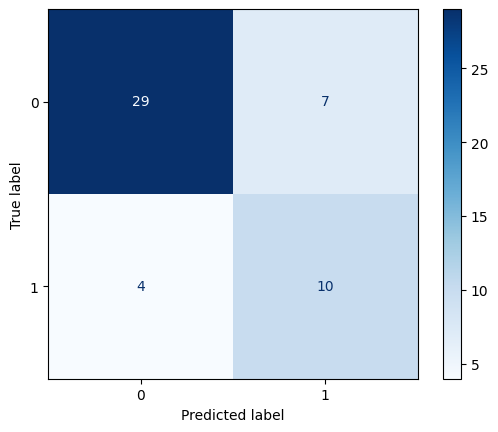

              precision    recall  f1-score   support

           0       0.88      0.81      0.84        36
           1       0.59      0.71      0.65        14

    accuracy                           0.78        50
   macro avg       0.73      0.76      0.74        50
weighted avg       0.80      0.78      0.79        50



In [5]:
classifier = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=50, class_weight={0:10, 1:0.5}), n_estimators=20, bootstrap=True, oob_score=True)

for iter in range(10):
    classifier.fit(data_train, target_train)
    target_predicted = classifier.predict(data_test)
    current_balanced_accuracy = balanced_accuracy_score(target_test, target_predicted)

    if iter == 0:
        best_fit = classifier
        best_balanced_accuracy = current_balanced_accuracy
    elif best_balanced_accuracy < current_balanced_accuracy:
        best_fit = classifier
        best_balanced_accuracy = current_balanced_accuracy

target_predicted = best_fit.predict(data_test)
generated_confusion_matrix = confusion_matrix(target_test, target_predicted)
display = ConfusionMatrixDisplay(confusion_matrix = generated_confusion_matrix)
display.plot(cmap = 'Blues')
plt.show()

generated_classification_report = classification_report(target_test, target_predicted, zero_division=0)
print(generated_classification_report)


### Random Forest

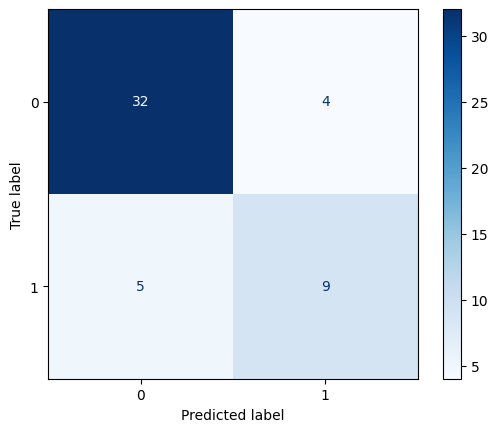

              precision    recall  f1-score   support

           0       0.86      0.89      0.88        36
           1       0.69      0.64      0.67        14

    accuracy                           0.82        50
   macro avg       0.78      0.77      0.77        50
weighted avg       0.82      0.82      0.82        50



In [6]:
classifier = RandomForestClassifier(max_depth=5, class_weight={0:1, 1:0.5}, n_estimators=10, bootstrap=True, oob_score=True)

for iter in range(10):
    classifier.fit(data_train, target_train)
    target_predicted = classifier.predict(data_test)
    current_balanced_accuracy = balanced_accuracy_score(target_test, target_predicted)

    if iter == 0:
        best_fit = classifier
        best_balanced_accuracy = current_balanced_accuracy
    elif best_balanced_accuracy < current_balanced_accuracy:
        best_fit = classifier
        best_balanced_accuracy = current_balanced_accuracy

target_predicted = best_fit.predict(data_test)
generated_confusion_matrix = confusion_matrix(target_test, target_predicted)
display = ConfusionMatrixDisplay(confusion_matrix = generated_confusion_matrix)
display.plot(cmap = 'Blues')
plt.show()

generated_classification_report = classification_report(target_test, target_predicted, zero_division=0)
print(generated_classification_report)


## Boosting Models

### AdaBoost

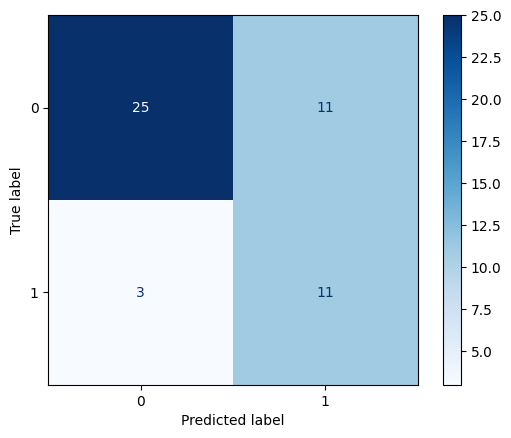

              precision    recall  f1-score   support

           0       0.89      0.69      0.78        36
           1       0.50      0.79      0.61        14

    accuracy                           0.72        50
   macro avg       0.70      0.74      0.70        50
weighted avg       0.78      0.72      0.73        50



In [7]:
classifier = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth=50, class_weight={0:10, 1:0.5}), n_estimators=1000, learning_rate=0.5)

for iter in range(10):
    classifier.fit(data_train, target_train)
    target_predicted = classifier.predict(data_test)
    current_balanced_accuracy = balanced_accuracy_score(target_test, target_predicted)

    if iter == 0:
        best_fit = classifier
        best_balanced_accuracy = current_balanced_accuracy
    elif best_balanced_accuracy < current_balanced_accuracy:
        best_fit = classifier
        best_balanced_accuracy = current_balanced_accuracy

target_predicted = best_fit.predict(data_test)
generated_confusion_matrix = confusion_matrix(target_test, target_predicted)
display = ConfusionMatrixDisplay(confusion_matrix = generated_confusion_matrix)
display.plot(cmap = 'Blues')
plt.show()

generated_classification_report = classification_report(target_test, target_predicted, zero_division=0)
print(generated_classification_report)

### XGBoost

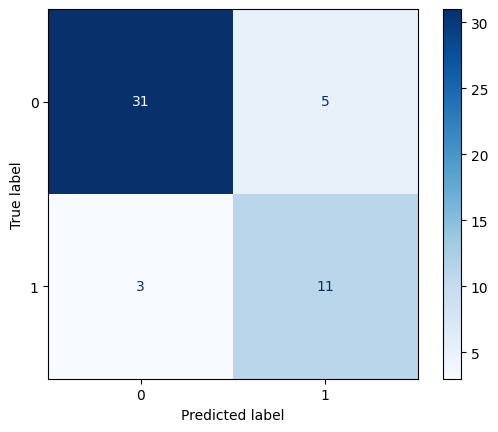

              precision    recall  f1-score   support

           0       0.91      0.86      0.89        36
           1       0.69      0.79      0.73        14

    accuracy                           0.84        50
   macro avg       0.80      0.82      0.81        50
weighted avg       0.85      0.84      0.84        50



In [8]:
classifier = XGBClassifier(n_estimators=1000, learning_rate=0.5, max_depth = 10)

for iter in range(10):
    classifier.fit(data_train, target_train)
    target_predicted = classifier.predict(data_test)
    current_balanced_accuracy = balanced_accuracy_score(target_test, target_predicted)

    if iter == 0:
        best_fit = classifier
        best_balanced_accuracy = current_balanced_accuracy
    elif best_balanced_accuracy < current_balanced_accuracy:
        best_fit = classifier
        best_balanced_accuracy = current_balanced_accuracy

target_predicted = best_fit.predict(data_test)
generated_confusion_matrix = confusion_matrix(target_test, target_predicted)
display = ConfusionMatrixDisplay(confusion_matrix = generated_confusion_matrix)
display.plot(cmap = 'Blues')
plt.show()

generated_classification_report = classification_report(target_test, target_predicted, zero_division=0)
print(generated_classification_report)